In [2]:
from utilities import io, GSP, ML, vis
import numpy as np 
from scipy.stats import zscore
from scipy.signal import hilbert 
import matplotlib.pylab as plt 
from scipy.io import savemat, loadmat
import os 
import nilearn as nl 
import os.path as op
from nilearn import plotting 
from nilearn.plotting import plot_markers
from nilearn import datasets 
from scipy.linalg import fractional_matrix_power as fmpower 
from scipy.stats import zscore
import pandas as pd 
from nilearn.connectome import ConnectivityMeasure
import seaborn as sns
from numpy.linalg import norm
import pingouin as pg
from statsmodels.stats.multitest import fdrcorrection 
from scipy.stats import ttest_rel, wilcoxon, permutation_test
import bct 
from functions import sc_average, cutoff_estimation
import nibabel as nb

## Initialization

In [3]:
data_dir = '/data/project/concussion/CosmonautsDTI/Denoised_All/'
results_sc_dir = '/data/project/concussion/CosmonautsDTI/results/SC_Analysis/'
results_gsp_dir = '/data/project/concussion/CosmonautsDTI/results/GSP_Analysis/'
results_scfc_dir = '/data/project/concussion/CosmonautsDTI/results/SCFC_Analysis/'
#other_addr = '/data/project/cosmonauts/Data/Others/'

if not os.path.exists(results_sc_dir): 
    os.mkdir(results_sc_dir)
if not os.path.exists(results_gsp_dir): 
    os.mkdir(results_gsp_dir)
if not os.path.exists(results_scfc_dir): 
    os.mkdir(results_scfc_dir)
    
subjects = os.listdir(data_dir)

subjects_prepost=["cont-01", "cont-02", "cont-03", "cont-04", "cont-05", "cont-06", 
                  "cont-07", "cont-08", "cont-09", "cont-10", "cont-11", "cont-12", "cont-13",
                  "cosm-01", "cosm-02", "cosm-04", "cosm-05", "cosm-07", "cosm-08",
                  "cosm-09", "cosm-10", "cosm-12", "cosm-14", "cosm-18"]

## SC Comparison

### DataFrame Creation

In [ ]:
# SC Edge Values 

flights = ['f1']
tps = ['pre2', 'post', 'followup']
atlases = ['SCH_100']

for atlas in atlases:
    df_edge = pd.DataFrame([])
    df_eig = pd.DataFrame([])
    df_graph_local = pd.DataFrame([])
    df_graph_global = pd.DataFrame([])
    if atlas == 'AAL3':
        R = 170
    elif atlas == 'HO':
        R = 63
    elif atlas == 'SCH_100':
        R = 119
    for sub in subjects:
        gp = sub.split('-')[0]
        for flight in flights:
            for tp in tps: 
                path = op.join(data_dir, sub, flight, tp)
                if op.isdir(path):
                    if f'{sub}-{tp}' != 'cosm-03-post': # This data was not preprocessed properly
                        print(f'{atlas} -- {sub} -- {flight} -- {tp}')
                        
                        # Reading SC
                        sc = np.loadtxt(op.join(data_dir, sub, flight, tp, f'SC_Norm_{atlas}.csv'), dtype='str', delimiter=',')
                        tmpsc = np.zeros(sc.shape)
                        for i in range(sc.shape[0]):
                            for j in range(sc.shape[1]):
                                tmpsc[i,j] = float(sc[i,j])
                        sc = tmpsc
                        
                        # df_edge
                        print(f'    Connection Values ...')
                        for i in range(R):
                            for j in range(i+1, R):
                                connval = sc[i,j]
                                tmpdf = pd.DataFrame([])
                                tmpdf['subject'] = [sub]
                                tmpdf['group'] = [gp]
                                tmpdf['flight'] = [flight]
                                tmpdf['time'] = [tp]
                                tmpdf['conn'] = [f'{i}-{j}']
                                tmpdf['val'] = [connval]
                                df_edge = pd.concat((df_edge, tmpdf), ignore_index=True)
                                
                        # df_eig
                        print(f'    Eigenvalues ...')
                        e, U = GSP.Graph_creation(sc, 'normalized')
                        for i in range(len(e)):
                            tmpdf = pd.DataFrame([])
                            tmpdf['subject'] = [sub]
                            tmpdf['group'] = [gp]
                            tmpdf['flight'] = [flight]
                            tmpdf['time'] = [tp]
                            tmpdf['eigenvalue'] = [f'e{i}']
                            tmpdf['val'] = [e[i]]
                            df_eig = pd.concat((df_eig, tmpdf), ignore_index=True)
                            
                        # df_graph_local
                        print(f'    Graph Local Metrics ...')
                        strength = bct.strengths_und(sc)
                        clust_coeff = bct.clustering_coef_wu(sc)
                        effic = bct.efficiency_wei(sc, local=True)
                        bet_cent = bct.betweenness_wei(sc)
                        for i in range(len(e)):
                            tmpdf = pd.DataFrame([])
                            tmpdf['subject'] = [sub]
                            tmpdf['group'] = [gp]
                            tmpdf['flight'] = [flight]
                            tmpdf['time'] = [tp]
                            tmpdf['region'] = [f'R{i}']
                            tmpdf['strength'] = [strength[i]]
                            tmpdf['clustering_coefficient'] = [clust_coeff[i]]
                            tmpdf['efficiency'] = [effic[i]]
                            tmpdf['betweenness_centrality'] = [bet_cent[i]]
                            df_graph_local = pd.concat((df_graph_local, tmpdf), ignore_index=True)
                            
                        # df_graph_global
                        print(f'    Graph Global Metrics ...')
                        density = bct.density_und(sc)[0]
                        clust_coeff = np.mean(bct.clustering_coef_wu(sc))
                        effic = bct.efficiency_wei(sc)
                        modul = bct.modularity_louvain_und(sc)[1]
                        tmpdf = pd.DataFrame([])
                        tmpdf['subject'] = [sub]
                        tmpdf['group'] = [gp]
                        tmpdf['flight'] = [flight]
                        tmpdf['time'] = [tp]
                        tmpdf['density'] = [density]
                        tmpdf['clustering_coefficient'] = [clust_coeff]
                        tmpdf['efficiency'] = [effic]
                        tmpdf['modularity'] = [modul]
                        df_graph_global = pd.concat((df_graph_global, tmpdf), ignore_index=True)
                                            
    df_edge.to_csv(op.join(results_sc_dir, f'SC_values_{atlas}.csv'))
    df_eig.to_csv(op.join(results_sc_dir, f'SC_Eigenvalues_{atlas}.csv'))
    df_graph_local.to_csv(op.join(results_sc_dir, f'SC_Graph_Local_{atlas}.csv'))
    df_graph_global.to_csv(op.join(results_sc_dir, f'SC_Graph_Global_{atlas}.csv'))

### Visualization

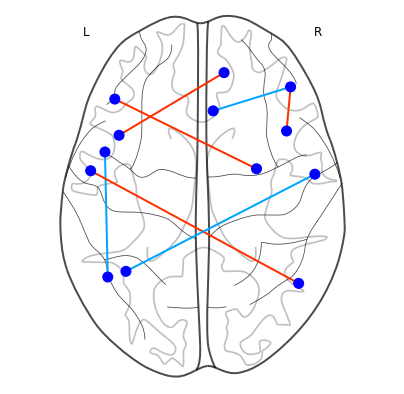

In [33]:
# SC Cpmparison 
R = 119
sc = np.zeros((R, R))
sc[15,21] = -1
sc[21,15] = -1
sc[33,61] = -1
sc[61,33] = -1
sc[34,72] = 1
sc[72,34] = 1
sc[37,52] = 1
sc[52,37] = 1
sc[46,96] = 1
sc[96,46] = 1
sc[83,85] = 1
sc[85,83] = 1
sc[83,87] = -1
sc[87,83] = -1
from nilearn import plotting 
import nibabel as nb
img = nb.load('/data/project/cosmonauts/Data/Atlas/SCH_100/img.nii')
coords = plotting.find_parcellation_cut_coords(labels_img=img)
f,a = plt.subplots(1,1, figsize=(7,7))

sizes = np.zeros(R)
size_val = 100
sizes[15] = size_val
sizes[33] = size_val
sizes[34] = size_val
sizes[37] = size_val
sizes[46] = size_val
sizes[83] = size_val
sizes[21] = size_val
sizes[61] = size_val
sizes[72] = size_val
sizes[52] = size_val
sizes[96] = size_val
sizes[85] = size_val
sizes[87] = size_val

plotting.plot_connectome(sc, coords, edge_kwargs={'linewidth':2}, 
                         node_color='blue', node_size=sizes, display_mode='z', axes=a, edge_cmap='jet', edge_vmin=-2, edge_vmax=1.5, annotate=True)
f.savefig(op.join(results_sc_dir, f'SC_value_SCH100_brain.png'), dpi=300)

/home/smortaheb/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_projectors.py:166: UserWarning: 'adjacency_matrix' is not symmetric. A directed graph will be plotted.
  warnings.warn(("'adjacency_matrix' is not symmetric. "


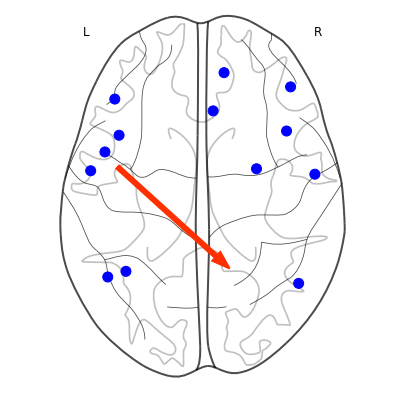

In [90]:
R = 119
sc = np.zeros((R, R))
sc[24,70] = 1

from nilearn import plotting 
import nibabel as nb
img = nb.load('/data/project/cosmonauts/Data/Atlas/SCH_100/img.nii')
coords = plotting.find_parcellation_cut_coords(labels_img=img)
f,a = plt.subplots(1,1, figsize=(7,7))
plotting.plot_connectome(sc, coords, edge_kwargs={'linewidth':2}, 
                         node_color='blue', node_size=sizes, display_mode='z', axes=a, edge_cmap='jet', edge_vmin=-2, edge_vmax=1.5, annotate=True)

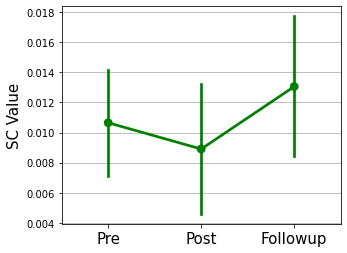

In [71]:
# Followup 
conn = "15-21"
df = pd.read_csv(op.join(results_sc_dir, f'SC_values_{atlas}.csv'))
data_fu = df[(df.subject == "cosm-03") | (df.subject == "cosm-04") | (df.subject == "cosm-05") | (df.subject == "cosm-07") | (df.subject == "cosm-09") |
               (df.subject == "cosm-10") | (df.subject == "cosm-11")]
data_fu = data_fu[data_fu.conn == conn]
f,a = plt.subplots(1,1, figsize=(5,4))
sns.pointplot(x='time', y='val', data=data_fu, color='green')
a.grid(True, axis='y')
a.set_xlabel('')
a.set_ylabel('SC Value', size=15)
a.set_xticklabels(['Pre', 'Post', 'Followup'], size=15)
f.savefig(op.join(results_sc_dir, f'SC_value_SCH100_FU_{conn}.png'), dpi=300)

## SC-FC Relationship

### DataFrame Creation

In [4]:
atlas = 'SCH_100'
if atlas == 'AAL3':
    R = 170
elif atlas == 'HO':
    R = 63
elif atlas == 'SCH_100':
    R = 119

# group-level SC averaging
cosm_pre_sc = sc_average('cosm', 'f1', 'pre2', atlas, data_dir)
cosm_post_sc = sc_average('cosm', 'f1', 'post', atlas, data_dir)
cosm_followup_sc = sc_average('cosm', 'f1', 'followup', atlas, data_dir)
cont_pre_sc = sc_average('cont', 'f1', 'pre2', atlas, data_dir)
cont_post_sc = sc_average('cont', 'f1', 'post', atlas, data_dir)

# SC eigen decomposition
kind = 'normalized' # Normalized Laplacian as the shift matrix 
e_cosm_pre, U_cosm_pre = GSP.Graph_creation(cosm_pre_sc, kind=kind)
e_cosm_post, U_cosm_post = GSP.Graph_creation(cosm_post_sc, kind=kind)
e_cosm_followup, U_cosm_followup = GSP.Graph_creation(cosm_followup_sc, kind=kind)
e_cont_pre, U_cont_pre = GSP.Graph_creation(cont_pre_sc, kind=kind)
e_cont_post, U_cont_post = GSP.Graph_creation(cont_post_sc, kind=kind)

# Cutoff frequency estimation 
c_cosm_pre, l_cosm_pre, MPSD_cosm_pre, SPSD_cosm_pre = cutoff_estimation('cosm', 'f1', 'pre2', atlas, data_dir, e_cosm_pre, U_cosm_pre)
c_cosm_post, l_cosm_post, MPSD_cosm_post, SPSD_cosm_post = cutoff_estimation('cosm', 'f1', 'post', atlas, data_dir, e_cosm_post, U_cosm_post)
c_cosm_followup, l_cosm_followup, MPSD_cosm_followup, SPSD_cosm_followup = cutoff_estimation('cosm', 'f1', 'followup', atlas, data_dir, e_cosm_followup, U_cosm_followup)
c_cont_pre, l_cont_pre, MPSD_cont_pre, SPSD_cont_pre = cutoff_estimation('cont', 'f1', 'pre2', atlas, data_dir, e_cont_pre, U_cont_pre)
c_cont_post, l_cont_post, MPSD_cont_post, SPSD_cont_post = cutoff_estimation('cont', 'f1', 'post', atlas, data_dir, e_cont_post, U_cont_post)

flights = ['f1']
tps = ['pre2', 'post', 'followup']

df_scfc_local = pd.DataFrame([])
df_scfc_global = pd.DataFrame([])

for sub in subjects:
    gp = sub.split('-')[0]
    for flight in flights:
        for tp in tps: 
            path = op.join(data_dir, sub, flight, tp)
            if op.isdir(path):
                
                # Parameter Initialization 
                sc = np.loadtxt(op.join(data_dir, sub, flight, tp, f'SC_Norm_{atlas}.csv'), dtype='str', delimiter=',')
                tmpsc = np.zeros(sc.shape)
                for i in range(sc.shape[0]):
                    for j in range(sc.shape[1]):
                        tmpsc[i,j] = float(sc[i,j])
                sc = tmpsc
                
                rs_file = op.join(data_dir, sub, flight, tp, f'Sig_{atlas}.txt')
                rs = np.loadtxt(rs_file)
                nrs = zscore(rs, axis=1)
                nrs = np.nan_to_num(nrs)
                  
                if f'{gp}-{tp}' == 'cosm-pre2':
                    U = U_cosm_pre
                    Ulow = np.zeros(U.shape)
                    Ulow[:, 0:c_cosm_pre-1] = U[:, 0:c_cosm_pre-1]
                    Uhigh = np.zeros(U.shape)
                    Uhigh[:,c_cosm_pre-1:R] = U[:, c_cosm_pre-1:R]
                elif f'{gp}-{tp}' == 'cosm-post':
                    U = U_cosm_post
                    Ulow = np.zeros(U.shape)
                    Ulow[:, 0:c_cosm_post-1] = U[:, 0:c_cosm_post-1]
                    Uhigh = np.zeros(U.shape)
                    Uhigh[:,c_cosm_post-1:R] = U[:, c_cosm_post-1:R]
                elif f'{gp}-{tp}' == 'cosm-followup':
                    U = U_cosm_followup
                    Ulow = np.zeros(U.shape)
                    Ulow[:, 0:c_cosm_followup-1] = U[:, 0:c_cosm_followup-1]
                    Uhigh = np.zeros(U.shape)
                    Uhigh[:,c_cosm_followup-1:R] = U[:, c_cosm_followup-1:R]
                elif f'{gp}-{tp}' == 'cont-pre2':
                    U = U_cont_pre
                    Ulow = np.zeros(U.shape)
                    Ulow[:, 0:c_cont_pre-1] = U[:, 0:c_cont_pre-1]
                    Uhigh = np.zeros(U.shape)
                    Uhigh[:,c_cont_pre-1:R] = U[:, c_cont_pre-1:R]
                elif f'{gp}-{tp}' == 'cont-post':
                    U = U_cont_post
                    Ulow = np.zeros(U.shape)
                    Ulow[:, 0:c_cont_post-1] = U[:, 0:c_cont_post-1]
                    Uhigh = np.zeros(U.shape)
                    Uhigh[:,c_cont_post-1:R] = U[:, c_cont_post-1:R]
                    
                
                # df_scfc_local    
                nrshat = np.matmul(U.T, nrs)
                xc = np.matmul(Ulow, nrshat)
                xd = np.matmul(Uhigh, nrshat)
                cind = np.linalg.norm(xc, axis=1)
                dind = np.linalg.norm(xd, axis=1)
                sdi = dind/cind
                for i in range(len(sdi)):
                    tmpdf = pd.DataFrame([])
                    tmpdf['subject'] = [sub]
                    tmpdf['flight'] = [flight]
                    tmpdf['time_point'] = [tp]
                    tmpdf['group'] = [gp]
                    tmpdf['region'] = [f'R{i}']
                    tmpdf['coupling'] = [cind[i]]
                    tmpdf['decoupling'] = [dind[i]]
                    tmpdf['sdi'] = [sdi[i]]
                    df_scfc_local = df_scfc_local.append(tmpdf, ignore_index=True)
                    
                # df_scfc_global 
                alg = np.linalg.norm(xc, axis=0)
                lib = np.linalg.norm(xd, axis=0)
                conn_method = ConnectivityMeasure(kind='correlation')
                fc_corr_mat = conn_method.fit_transform([nrs.T])
                idx = np.tril_indices(R, k=-1)
                fcmat = fc_corr_mat[0][idx]
                scmat = sc[idx]
                scfc_corr = np.corrcoef(fcmat, scmat)[0,1]
                tmpdf = pd.DataFrame([])
                tmpdf['subject'] = [sub]
                tmpdf['flight'] = [flight]
                tmpdf['time_point'] = [tp]
                tmpdf['group'] = [gp]
                tmpdf['alignmnet'] = [np.mean(alg)]
                tmpdf['liberality'] = [np.mean(lib)]
                tmpdf['sc-fc'] = [scfc_corr]
                df_scfc_global = df_scfc_global.append(tmpdf, ignore_index=True)
                
#df_scfc_local.to_csv(op.join(results_gsp_dir, f'SCFC_Local_{atlas}.csv'))
#df_scfc_global.to_csv(op.join(results_gsp_dir, f'SCFC_Global_{atlas}.csv'))

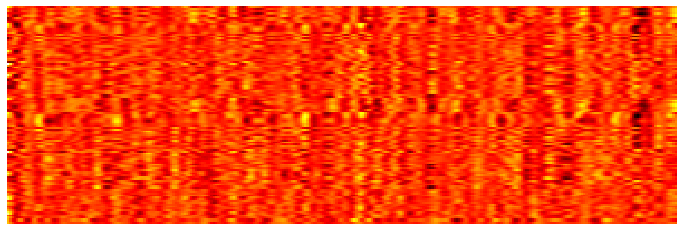

In [5]:
mode = 'coupling'

if mode == 'coupling':
    x = xc
    name = 'x_low'
elif mode == 'decoupling':
    x = xd
    name = 'x_high'

f, a = plt.subplots(1,1, figsize=(12,4))
sns.heatmap(x, cmap='hot', cbar=False)
plt.xticks([])
plt.yticks([])
f.savefig(op.join(results_gsp_dir, f'{name}.pdf'), dpi=300)

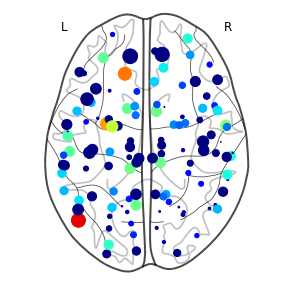

In [13]:
atlas_dir = '/data/project/dynamic_brain_mind/Data/Atlases/'
atlas_type = 'SCH_100'

img = nb.load(op.join(atlas_dir, atlas_type, 'img.nii'))
coords = plotting.find_parcellation_cut_coords(labels_img=img)

f, a = plt.subplots(1,1, figsize=(5,5))

sdi = dind/cind

mode = 'decoupling'

if mode == 'coupling':
    vec = cind
    name = 'x_c'
    coeff = 10
elif mode == 'decoupling':
    vec = dind
    name = 'x_d'
    coeff = 10
elif mode == 'sdi':
    vec = sdi
    name = 'sdi'
    coeff = 100

vec = xd[:,100]
coeff=100

plotting.plot_markers(vec, coords, 
                      alpha=1,
                      node_vmin=0, 
                      node_vmax=np.max([np.abs(np.min(vec)), np.abs(np.max(vec))]),
                      node_cmap='jet', 
                      display_mode='z', 
                      colorbar=False,
                      axes=a, 
                      node_size = abs(coeff*vec))

f.savefig(op.join(results_gsp_dir, f'graph_signal_high.pdf'), dpi=300)

### Visualization

In [49]:
# For SDI Map
atlas_dir = '/data/project/cosmonauts/Data/Atlas/'
atlas = 'SCH_100'
img = nb.load(op.join(atlas_dir, atlas, 'img.nii'))
data = img.get_fdata()
header = img.header

data_res = np.zeros(data.shape)
idx = np.where(data==25)
data_res[idx]=0.230
idx = np.where(data==71)
data_res[idx]=-0.367

img_res = nb.Nifti1Image(data_res, img.affine, img.header)
nb.save(img_res, op.join(results_gsp_dir, f'sdi_significant_vec_{atlas}.nii'))

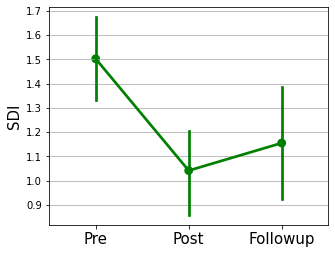

In [86]:
# Followup 
reg = "R70"
df = pd.read_csv(op.join(results_gsp_dir, f'SCFC_Local_{atlas}.csv'))
data_fu = df[(df.subject == "cosm-03") | (df.subject == "cosm-04") | (df.subject == "cosm-05") | (df.subject == "cosm-07") | (df.subject == "cosm-09") |
               (df.subject == "cosm-10") | (df.subject == "cosm-11")]
data_fu = data_fu[data_fu.region == reg]
f,a = plt.subplots(1,1, figsize=(5,4))
sns.pointplot(x='time_point', y='sdi', data=data_fu, color='green')
a.grid(True, axis='y')
a.set_xlabel('')
a.set_ylabel('SDI', size=15)
a.set_xticklabels(['Pre', 'Post', 'Followup'], size=15)
f.savefig(op.join(results_gsp_dir, f'SCFC_SDI_SCH100_FU_{reg}.png'), dpi=300)

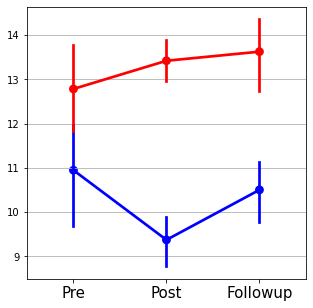

In [89]:
# Coupling and Decoupling
reg = "R24"
df = pd.read_csv(op.join(results_gsp_dir, f'SCFC_Local_{atlas}.csv'))
data_fu = df[(df.subject == "cosm-03") | (df.subject == "cosm-04") | (df.subject == "cosm-05") | (df.subject == "cosm-07") | (df.subject == "cosm-09") |
               (df.subject == "cosm-10") | (df.subject == "cosm-11")]
data_fu = data_fu[data_fu.region == reg]
f,a = plt.subplots(1,1, figsize=(5,5))
sns.pointplot(x='time_point', y='coupling', data=data_fu, color='blue', axis=a)
a.grid(True, axis='y')
a.set_xlabel('')
a.set_ylabel('', size=15)
a.set_xticklabels(['Pre', 'Post', 'Followup'], size=15)

sns.pointplot(x='time_point', y='decoupling', data=data_fu, color='red', axis=a)
a.grid(True, axis='y')
a.set_xlabel('')
a.set_ylabel('', size=15)
a.set_xticklabels(['Pre', 'Post', 'Followup'], size=15)


f.savefig(op.join(results_gsp_dir, f'SCFC_CouplingDecoupling_SCH100_FU_{reg}.png'), dpi=300)